## Setup

In [1]:
# Setup and Initialization
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns

# Sklearn metrics for evaluation
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, confusion_matrix, classification_report
import statsmodels.api as sm
from scipy import stats
from sklearn.calibration import calibration_curve # Import calibration_curve for decomposition
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt

# Google Drive Mounting and Paths
from google.colab import drive
drive.mount('/content/drive')

# Paths to directories
BASE_PATH = "/content/drive/MyDrive/Diffusion_Indices_Project/"
INTERMEDIATE_PATH = os.path.join(BASE_PATH, "03_intermediate_data")
RESULTS_PATH = os.path.join(BASE_PATH, "04_results")
OOS_PRED_PATH = os.path.join(RESULTS_PATH, "oos_predictions")
VISUALS_PATH = os.path.join(BASE_PATH, "05_visuals")

os.makedirs(VISUALS_PATH, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Set horizon

In [48]:
# Results for horizon
PREDICTION_HORIZON = 1

## Plotting parameters

In [49]:
# Use a serif font that matches LaTeX's Computer Modern
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'DejaVu Serif' # Or 'Computer Modern Roman', if installed
mpl.rcParams['text.usetex'] = False # Set to True if you have a full LaTeX installation and want to render math text

# Set font sizes for consistency
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11
mpl.rcParams['axes.titlesize'] = 14

# Set line widths and styles
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['patch.linewidth'] = 1.0

# Set grid properties
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['grid.color'] = '#A9A9A9' # DarkGray

# Set figure properties
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'

# Remove unnecessary spines
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

print("Matplotlib parameters set for LaTeX aesthetic.")

Matplotlib parameters set for LaTeX aesthetic.


## Loading results, probabilities, and ensembles

In [50]:
# Load the Out-of-Sample (OOS) Results
print("Step 2: Loading OOS results from the forecasting loop...")
try:
    file_path = os.path.join(OOS_PRED_PATH, f'oos_results_h{PREDICTION_HORIZON}.pkl')
    oos_results = joblib.load(file_path)
    print(f"Successfully loaded results from: {file_path}")
except FileNotFoundError:
    print(f"ERROR: Results file not found at {file_path}. Please run Notebook 2 first.")
    oos_results = None

# Extract the components
if oos_results:
    oos_probs = oos_results['probabilities']
    oos_errors = oos_results['squared_errors']
    oos_actuals = oos_results['actuals']

X_untransformed_full = pd.read_pickle(os.path.join(INTERMEDIATE_PATH, 'X_untransformed_monthly.pkl'))
y_target_full = pd.read_pickle(os.path.join(INTERMEDIATE_PATH, 'y_target.pkl'))


Step 2: Loading OOS results from the forecasting loop...
Successfully loaded results from: /content/drive/MyDrive/Diffusion_Indices_Project/04_results/oos_predictions/oos_results_h1.pkl


In [51]:
print("\nDataFrame of predicted probabilities...")

# We will create a single DataFrame to easily view and compare the probabilities
all_probs_list = []
for pred_set, models_dict in oos_probs.items():
    for model_name, prob_list in models_dict.items():
        # Create a name for the column
        col_name = f"{pred_set}_{model_name}"
        # Create a pandas Series with the correct dates as the index
        s = pd.Series(prob_list, index=oos_actuals.index, name=col_name)
        all_probs_list.append(s)

# Concatenate all series into a single DataFrame
prob_df = pd.concat(all_probs_list, axis=1)
# Add the actual outcomes for comparison
prob_df['Actual_Recession'] = oos_actuals


DataFrame of predicted probabilities...


In [52]:
print(" Creating Ensemble Forecasts for Each Predictor Set ")

# Define the models that make up the ensemble for each set
models_in_ensemble = ['Logit', 'Logit_L1', 'HGBoost', 'XGBoost', 'RandomForest']

# Define the predictor sets we want to create ensembles for
frameworks_to_compare = [
    'PCA_Factors_8',
    'Yield',
    'Full',
    'ADS',
    'TFDI',
    'Weakness',
    'Deter'
]

# Loop through each framework and create its ensemble forecast
for framework in frameworks_to_compare:
    ensemble_name = f"{framework}_Ensemble"

    # Get the column names for the models in this framework's ensemble
    model_columns = [f"{framework}_{model}" for model in models_in_ensemble if f"{framework}_{model}" in prob_df.columns]

    if model_columns:
        # Calculate the average probability across the models
        prob_df[ensemble_name] = prob_df[model_columns].mean(axis=1)
        print(f"Successfully created: {ensemble_name}")
    else:
        print(f"Warning: No model columns found for framework '{framework}'.")

# Display the head of the new columns to verify
new_cols = [f"{f}_Ensemble" for f in frameworks_to_compare if f"{f}_Ensemble" in prob_df.columns]
print("\n Verifying new ensemble columns (Head) ")
print(prob_df[new_cols].head())

 Creating Ensemble Forecasts for Each Predictor Set 
Successfully created: PCA_Factors_8_Ensemble
Successfully created: Yield_Ensemble
Successfully created: Full_Ensemble
Successfully created: ADS_Ensemble
Successfully created: TFDI_Ensemble
Successfully created: Weakness_Ensemble
Successfully created: Deter_Ensemble

 Verifying new ensemble columns (Head) 
            PCA_Factors_8_Ensemble  Yield_Ensemble  Full_Ensemble  \
Date                                                                
1990-01-01                0.057490        0.183628       0.022220   
1990-02-01                0.054496        0.225495       0.048078   
1990-03-01                0.006044        0.288533       0.051481   
1990-04-01                0.006148        0.319690       0.020213   
1990-05-01                0.049064        0.300885       0.064346   

            ADS_Ensemble  TFDI_Ensemble  Weakness_Ensemble  Deter_Ensemble  
Date                                                                        
19

## Helper functions
1. Create asymmetric loss function
2. Decompose Brier Score
3. Create DM test function

In [53]:
def get_asymmetric_loss_series(y_true, y_prob, theta, index=None):
    """
    Calculates a series of squared errors under asymmetric loss, where missing
    a positive event (y=1) is weighted more heavily.
    """
    # Ensure inputs are numpy arrays for calculations
    y_true_np, y_prob_np = np.asarray(y_true), np.asarray(y_prob)

    # Loss when a recession occurs (y_t = 1)
    loss_recession = theta * ((1 - y_prob_np)**2)

    # Loss when no recession occurs (y_t = 0)
    loss_no_recession = (1 - theta) * ((y_prob_np)**2)

    # Apply the correct loss based on the actual outcome
    total_loss = np.where(y_true_np == 1, loss_recession, loss_no_recession)

    # Determine the index for the output Series
    if index is not None:
        output_index = index
    elif isinstance(y_true, pd.Series):
        output_index = y_true.index
    else:
        # If y_true is not a Series and no index is provided, create a default index
        output_index = pd.RangeIndex(start=0, stop=len(total_loss))


    return pd.Series(total_loss, index=output_index)

In [54]:
# Function for Brier Score Decomposition
def brier_score_decomposition(y_true, y_prob, n_bins=10):
    """
    Decomposes the Brier Score into its Reliability, Resolution, and Uncertainty components
    using the standard weighted approach based on binning.
    """
    # Ensure inputs are numpy arrays for calculations
    y_true_np = np.asarray(y_true)
    y_prob_np = np.asarray(y_prob)

    if len(y_true_np) == 0:
         return {'Reliability': np.nan, 'Resolution': np.nan, 'Uncertainty': np.nan}

    # Calculate overall base rate (uncertainty component)
    p_bar = y_true_np.mean()
    uncertainty = p_bar * (1 - p_bar)

    # Use calibration_curve to get mean predicted prob vs mean actual prob in bins
    # It also returns the number of observations in each bin if return_counts=True (requires newer sklearn)
    # We'll manually bin and count for broader compatibility

    # Bin the predicted probabilities
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    bin_indices = np.digitize(y_prob_np, bins)

    reliability = 0
    resolution = 0
    N = len(y_true_np)

    for i in range(1, n_bins + 1):
        bin_mask = (bin_indices == i)
        if not np.any(bin_mask):
            continue

        y_true_bin = y_true_np[bin_mask]
        y_prob_bin = y_prob_np[bin_mask]
        N_k = len(y_true_bin)

        p_bar_k = y_true_bin.mean() # Mean actual outcome in bin k
        p_k = y_prob_bin.mean() # Mean predicted probability in bin k

        # Reliability component (weighted squared difference between actual mean in bin and predicted mean in bin)
        reliability += (N_k / N) * (p_bar_k - p_k)**2

        # Resolution component (weighted squared difference between actual mean in bin and overall actual mean)
        resolution += (N_k / N) * (p_bar_k - p_bar)**2

    return {'Reliability': reliability, 'Resolution': resolution, 'Uncertainty': uncertainty}

In [55]:
def diebold_mariano_test_robust(loss1, loss2, h=1):
    """
    Performs the Diebold-Mariano test with the Harvey, Leybourne, & Newbold (1997)
    small-sample correction. The p-value is calculated using a Student's t-distribution.
    """
    loss_diff = (pd.Series(loss1) - pd.Series(loss2)).dropna()
    n = len(loss_diff)
    if n < 1:
        return np.nan, np.nan, "Not enough observations."

    d_mean = loss_diff.mean()

    # Calculate long-run variance (Newey-West)
    gamma0 = loss_diff.var(ddof=0)
    if n > 1 and gamma0 > 0:
        gamma_sum = 0
        for lag in range(1, h):
            autocov = loss_diff.autocorr(lag=lag) * gamma0
            gamma_sum += (1 - lag / h) * autocov
        long_run_var = gamma0 + 2 * gamma_sum
    else:
        long_run_var = gamma0

    if long_run_var <= 0:
        return np.nan, np.nan, "Non-positive long-run variance."

    dm_stat_standard = d_mean / np.sqrt(long_run_var / n)

    # HLN Small-Sample Correction
    # This correction is often applied, especially for h=1
    correction_factor = np.sqrt((n + 1 - 2*h + (h*(h-1))/n) / n)
    dm_stat_corrected = dm_stat_standard * correction_factor

    # Use the Student's t-distribution for the p-value
    p_value = 2 * stats.t.sf(np.abs(dm_stat_corrected), df=n-1)

    return dm_stat_corrected, p_value, f"Test run on {n} obs."



## Fundamental Metrics

In [56]:
print("\nCalculating and displaying performance metrics...")

metrics_list = []
y_true_full = oos_actuals

for pred_set, models_dict in oos_probs.items():
    for model_name, prob_list in models_dict.items():

        # Create a pandas Series using the same DatetimeIndex as the actuals
        y_prob = pd.Series(prob_list, index=y_true_full.index)

        # Create boolean mask with datetime index
        valid_idx = y_prob.notna()

        if valid_idx.sum() == 0:
            print(f"Skipping {pred_set}_{model_name} - No valid predictions.")
            continue

        y_true_eval = y_true_full[valid_idx]
        y_prob_eval = y_prob[valid_idx]

        # Ensure there are still positive and negative classes to evaluate
        if len(y_true_eval.unique()) < 2:
            print(f"Skipping {pred_set}_{model_name} - Only one class present after dropping NaNs.")
            continue

        # Calculate metrics
        pr_auc = average_precision_score(y_true_eval, y_prob_eval)
        roc_auc = roc_auc_score(y_true_eval, y_prob_eval)
        brier = brier_score_loss(y_true_eval, y_prob_eval)

        metrics_list.append({
            'Predictor_Set': pred_set,
            'Model': model_name,
            'PR_AUC': pr_auc,
            'ROC_AUC': roc_auc,
            'Brier_Score': brier,
            'Num_Forecasts': len(y_prob_eval)
        })

results_df = pd.DataFrame(metrics_list)
if not results_df.empty:
    results_df = results_df.sort_values(by='PR_AUC', ascending=False).round(4)

print("\n Out-of-Sample Performance Summary ")
results_df


Calculating and displaying performance metrics...

 Out-of-Sample Performance Summary 


,Predictor_Set,Model,PR_AUC,ROC_AUC,Brier_Score,Num_Forecasts
4,Yield,RandomForest,0.9162,0.9828,0.0221,420
2,Yield,HGBoost,0.9122,0.9795,0.0300,420
23,TFDI,XGBoost,0.9085,0.9887,0.0188,420
14,PCA_Factors_8,RandomForest,0.9054,0.9747,0.0181,420
20,TFDI,Logit,0.8981,0.9798,0.0197,420
30,Deter,Logit,0.8947,0.9880,0.0296,420
29,Weakness,RandomForest,0.8934,0.9865,0.0185,420
3,Yield,XGBoost,0.8903,0.9696,0.0191,420
34,Deter,RandomForest,0.8876,0.9888,0.0188,420
33,Deter,XGBoost,0.8817,0.9887,0.0190,420


In [57]:
# Calculate metrics for each ensemble
ensemble_metrics_list = []
ensemble_cols = [col for col in prob_df.columns if 'Ensemble' in col]

for ensemble_col in ensemble_cols:
    y_prob = prob_df[ensemble_col]
    y_true_eval = prob_df['Actual_Recession']

    # Ensure both series have the same index and align NaNs
    valid_idx = y_prob.notna() & y_true_eval.notna()

    if valid_idx.sum() == 0:
        print(f"Skipping {ensemble_col} - No valid predictions.")
        continue

    y_true_eval_filtered = y_true_eval[valid_idx]
    y_prob_eval_filtered = y_prob[valid_idx]

    # Ensure there are still positive and negative classes to evaluate
    if len(y_true_eval_filtered.unique()) < 2:
        print(f"Skipping {ensemble_col} - Only one class present after dropping NaNs.")
        continue

    # Calculate metrics
    pr_auc = average_precision_score(y_true_eval_filtered, y_prob_eval_filtered)
    roc_auc = roc_auc_score(y_true_eval_filtered, y_prob_eval_filtered)
    brier = brier_score_loss(y_true_eval_filtered, y_prob_eval_filtered)


    # Calculate Brier Score Decomposition using the corrected function
    brier_decomp = brier_score_decomposition(y_true_eval_filtered, y_prob_eval_filtered)


    ensemble_metrics_list.append({
        'Predictor_Set_Model': ensemble_col,
        'PR_AUC': pr_auc,
        'ROC_AUC': roc_auc,
        'Brier_Score': brier,
        'Resolution': brier_decomp['Resolution'],
        'Reliability': brier_decomp['Reliability'],
        'Uncertainty': brier_decomp['Uncertainty'],
        'Num_Forecasts': len(y_prob_eval_filtered)
    })

# Create a DataFrame for ensemble results
ensemble_results_df = pd.DataFrame(ensemble_metrics_list)

if not ensemble_results_df.empty:
    # Reorder columns for better readability
    cols = ['Predictor_Set_Model', 'PR_AUC', 'ROC_AUC', 'Brier_Score',
            'Resolution', 'Reliability', 'Uncertainty', 'Num_Forecasts']
    ensemble_results_df = ensemble_results_df[cols].sort_values(by='PR_AUC', ascending=False).round(4)

print("\n Ensemble Model Performance Summary ")
ensemble_results_df


 Ensemble Model Performance Summary 


,Predictor_Set_Model,PR_AUC,ROC_AUC,Brier_Score,Resolution,Reliability,Uncertainty,Num_Forecasts
4,TFDI_Ensemble,0.9412,0.9924,0.0173,0.0699,0.0016,0.0862,420
6,Deter_Ensemble,0.9334,0.9920,0.0188,0.0712,0.0044,0.0862,420
0,PCA_Factors_8_Ensemble,0.9069,0.9783,0.0177,0.0689,0.0008,0.0862,420
5,Weakness_Ensemble,0.9024,0.9853,0.0187,0.0692,0.0018,0.0862,420
1,Yield_Ensemble,0.8795,0.9832,0.0404,0.0605,0.0147,0.0862,420
2,Full_Ensemble,0.8777,0.9778,0.0184,0.0682,0.0004,0.0862,420
3,ADS_Ensemble,0.8400,0.9710,0.0293,0.0689,0.0117,0.0862,420



Visualizing predicted probabilities...

Plotting Benchmark (PCA Ensemble) vs. Top Performer (TFDI Ensemble)


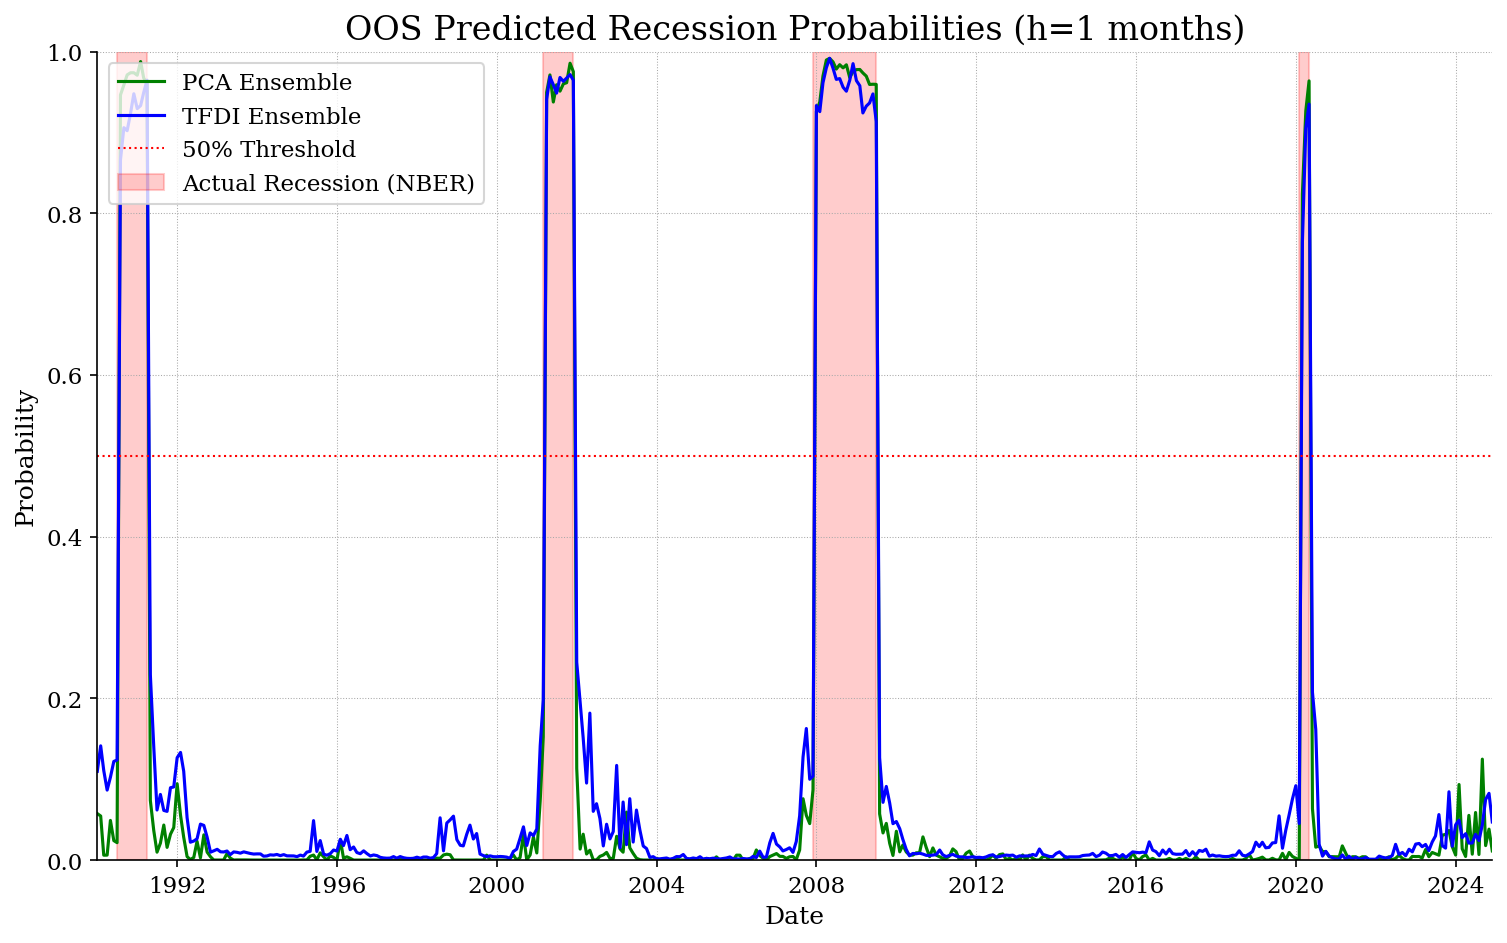

In [15]:
# Visualize the Probabilities Over Time
print("\nVisualizing predicted probabilities...")

if not results_df.empty:
    # title variables are what we want displayed on the graph
    benchmark_model = 'PCA_Factors_8_Ensemble'
    benchmark_title = 'PCA Ensemble'

    challenger_model = 'TFDI_Ensemble'
    challenger_title = 'TFDI Ensemble'

    print(f"\nPlotting Benchmark ({benchmark_title}) vs. Top Performer ({challenger_title})")

    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot the models' probabilities
    ax.plot(prob_df.index, prob_df[benchmark_model], label=f'{benchmark_title}', color='green')
    ax.plot(prob_df.index, prob_df[challenger_model], label=f'{challenger_title}', color='blue')

    # Add a horizontal line for the 50% probability threshold
    ax.axhline(0.5, color='red', linestyle=':', linewidth=1, label='50% Threshold')

    # Shade the actual NBER recession periods
    y_target_full_for_shading = pd.read_pickle(os.path.join(INTERMEDIATE_PATH, 'y_target.pkl'))

    in_recession = False
    shade_start = None
    for date, value in y_target_full_for_shading['USRECM'].items():
        if value == 1 and not in_recession:
            shade_start = date
            in_recession = True
        elif value == 0 and in_recession:
            ax.axvspan(shade_start, date, color='red', alpha=0.2, label='_nolegend_')
            in_recession = False
    if in_recession: # handle recession at the end of the data
        ax.axvspan(shade_start, y_target_full_for_shading.index[-1], color='red', alpha=0.2, label='_nolegend_')


    if any(y_target_full_for_shading['USRECM'] == 1):
        ax.fill_between([],[], color='red', alpha=0.2, label='Actual Recession (NBER)')


    ax.set_title(f'OOS Predicted Recession Probabilities (h={PREDICTION_HORIZON} months)', fontsize=16)
    ax.set_ylabel('Probability')
    ax.set_xlabel('Date')
    ax.legend(loc='upper left')
    ax.grid(True, axis='y', linestyle=':')
    ax.set_ylim(0, 1)

    # Dates to visualize
    ax.set_xlim(prob_df.index.min(), prob_df.index.max())
    # plt.savefig(os.path.join(VISUALS_PATH, 'TFDI_PCA_1998.pdf'), bbox_inches='tight', dpi=300)
    plt.show()
else:
    print("\nNo valid results to visualize.")

In [16]:
print("\n Confusion Matrix Analysis for Model ")


THRESHOLD = 0.5

model_name = 'Deter_Ensemble'

# Get the probabilities for this model from the prob_df DataFrame
y_prob_model = prob_df[model_name].dropna()

# Align with actuals
y_true_aligned = prob_df['Actual_Recession'].loc[y_prob_model.index]

# Create binary predictions based on the threshold
y_pred_model = (y_prob_model >= THRESHOLD).astype(int)

# Generate and print the confusion matrix
cm = confusion_matrix(y_true_aligned, y_pred_model)
print(f"Confusion Matrix for: {model_name} (Threshold = {THRESHOLD})")
print(cm)

# For better readability, print it with labels
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Correctly predicted no recession): {tn}")
print(f"False Positives (Predicted recession, but none occurred): {fp}")
print(f"False Negatives (Predicted no recession, but one occurred): {fn}")
print(f"True Positives (Correctly predicted recession): {tp}")

print("\nFull Classification Report:")
print(classification_report(y_true_aligned, y_pred_model))


 Confusion Matrix Analysis for Model 
Confusion Matrix for: Deter_Ensemble (Threshold = 0.5)
[[376   4]
 [  4  36]]
True Negatives (Correctly predicted no recession): 376
False Positives (Predicted recession, but none occurred): 4
False Negatives (Predicted no recession, but one occurred): 4
True Positives (Correctly predicted recession): 36

Full Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       380
         1.0       0.90      0.90      0.90        40

    accuracy                           0.98       420
   macro avg       0.94      0.94      0.94       420
weighted avg       0.98      0.98      0.98       420



## Forecast Encompassing Test

In [58]:
print("\n Forecast Encompassing Regressions ")

import statsmodels.api as sm
import pandas as pd
import numpy as np

# Helper Function for Logit Transform
def logit_transform(p):
    """Clamps probabilities and applies the logit transformation."""
    p_clamped = np.clip(p, 1e-6, 1 - 1e-6)
    return np.log(p_clamped / (1 - p_clamped))

# Function to run a single encompassing test
def run_encompassing_test(y_true, prob_challenger, prob_benchmark, challenger_name, benchmark_name):
    """
    Runs a Probit encompassing regression and prints a formatted conclusion.
    Tests if the challenger forecast encompasses the benchmark forecast.
    """
    print(f"\n Testing if '{challenger_name}' encompasses '{benchmark_name}' ")

    # Transform probabilities to logits
    logit_challenger = logit_transform(prob_challenger)
    logit_benchmark = logit_transform(prob_benchmark)

    # Create the regression design matrix
    X = pd.DataFrame({
        'const': 1,
        'logit_challenger': logit_challenger,
        'logit_benchmark': logit_benchmark
    })

    # Run the Probit regression
    try:
        model = sm.Probit(y_true, X).fit(disp=0) # disp=0 suppresses convergence output
    except Exception as e:
        print(f"Could not fit Probit model for this pair: {e}")
        return

    challenger_coeff = model.params['logit_challenger']
    benchmark_coeff = model.params['logit_benchmark']

    # Perform and Interpret the Hypothesis Tests
    p_challenger_is_zero = model.pvalues['logit_challenger']
    p_benchmark_is_zero = model.pvalues['logit_benchmark']

    alpha = 0.10

    # Interpretation
    challenger_is_significant = p_challenger_is_zero < alpha
    benchmark_is_significant = p_benchmark_is_zero < alpha

    print(f"   > Challenger ({challenger_name}): Coeff = {challenger_coeff:.3f}, p-value = {p_challenger_is_zero:.4f}")
    print(f"   > Benchmark ({benchmark_name}): Coeff = {benchmark_coeff:.3f}, p-value = {p_benchmark_is_zero:.4f}")

    if challenger_is_significant and not benchmark_is_significant:
        print(f"CONCLUSION: SUCCESS. The '{challenger_name}' forecast ENCOMPASSES the '{benchmark_name}' forecast.")
        print(f"   (p-value for Challenger: {p_challenger_is_zero:.4f}, p-value for Benchmark: {p_benchmark_is_zero:.4f})")
    elif challenger_is_significant and benchmark_is_significant:
        print(f"CONCLUSION: Both forecasts contain unique, valuable information. A combined forecast would be optimal.")
        print(f"   (p-value for Challenger: {p_challenger_is_zero:.4f}, p-value for Benchmark: {p_benchmark_is_zero:.4f})")
    elif not challenger_is_significant and not benchmark_is_significant:
        print(f"CONCLUSION: Test is inconclusive; neither forecast adds significant value to the other.")
        print(f"   (p-value for Challenger: {p_challenger_is_zero:.4f}, p-value for Benchmark: {p_benchmark_is_zero:.4f})")
    else: # not challenger_is_significant and benchmark_is_significant
        print(f"CONCLUSION: FAILURE. The '{benchmark_name}' forecast encompasses the '{challenger_name}' forecast.")
        print(f"   (p-value for Challenger: {p_challenger_is_zero:.4f}, p-value for Benchmark: {p_benchmark_is_zero:.4f})")


challenger = 'TFDI_Ensemble'
benchmarks_to_test = ['Deter_Ensemble', 'Weakness_Ensemble', 'PCA_Factors_8_Ensemble', 'ADS_Ensemble', 'Yield_Ensemble', 'Full_Ensemble']



# Loop to Run All Comparisons
for benchmark in benchmarks_to_test:
    # Align data for this specific pair and drop any NaNs
    aligned_df = prob_df[['Actual_Recession', challenger, benchmark]].dropna()

    if aligned_df.empty:
        print(f"\nSkipping {benchmark} due to no overlapping data.")
        continue

    y_true_final = aligned_df['Actual_Recession']
    pred_challenger = aligned_df[challenger]
    pred_benchmark = aligned_df[benchmark]

    # Run the test for this challenger-benchmark pair
    run_encompassing_test(y_true_final, pred_challenger, pred_benchmark, challenger, benchmark)


 Forecast Encompassing Regressions 

 Testing if 'TFDI_Ensemble' encompasses 'Deter_Ensemble' 
   > Challenger (TFDI_Ensemble): Coeff = 0.551, p-value = 0.1559
   > Benchmark (Deter_Ensemble): Coeff = -0.037, p-value = 0.9258
CONCLUSION: Test is inconclusive; neither forecast adds significant value to the other.
   (p-value for Challenger: 0.1559, p-value for Benchmark: 0.9258)

 Testing if 'TFDI_Ensemble' encompasses 'Weakness_Ensemble' 
   > Challenger (TFDI_Ensemble): Coeff = 0.913, p-value = 0.0031
   > Benchmark (Weakness_Ensemble): Coeff = -0.351, p-value = 0.1670
CONCLUSION: SUCCESS. The 'TFDI_Ensemble' forecast ENCOMPASSES the 'Weakness_Ensemble' forecast.
   (p-value for Challenger: 0.0031, p-value for Benchmark: 0.1670)

 Testing if 'TFDI_Ensemble' encompasses 'PCA_Factors_8_Ensemble' 
   > Challenger (TFDI_Ensemble): Coeff = 0.598, p-value = 0.0045
   > Benchmark (PCA_Factors_8_Ensemble): Coeff = -0.061, p-value = 0.6725
CONCLUSION: SUCCESS. The 'TFDI_Ensemble' forecast ENC

In [ ]:
print("\n Information Criterion Analysis (AIC/BIC) ")

# We will use the final aligned data from the last loop iteration
aligned_df = prob_df[['Actual_Recession', 'Deter_Ensemble', 'PCA_Factors_8_Ensemble']].dropna()
y_true = aligned_df['Actual_Recession']
prob_hadi = aligned_df['Deter_Ensemble']
prob_pca = aligned_df['PCA_Factors_8_Ensemble']

# Transform the probabilities to logits
logit_hadi = logit_transform(prob_hadi)
logit_pca = logit_transform(prob_pca)

# Model 1: Combined Encompassing Model
print("\nFitting Combined Model: y ~ TFDI + PCA")
X_full = pd.DataFrame({
    'const': 1,
    'logit_hadi': logit_hadi,
    'logit_pca': logit_pca
})
model_full = sm.Probit(y_true, X_full).fit(disp=0)

# DI-Only Model
print("Fitting Restricted Model: y ~ TFDI")
X_hadi_only = X_full[['const', 'logit_hadi']]
model_hadi_only = sm.Probit(y_true, X_hadi_only).fit(disp=0)

# PCA-Only Model
print("Fitting Restricted Model: y ~ PCA")
X_pca_only = X_full[['const', 'logit_pca']]
model_pca_only = sm.Probit(y_true, X_pca_only).fit(disp=0)


# Create and Display the Comparison Table
results = {
    'Model': ['TFDI + PCA (Full)', 'TFDI Only', 'PCA Only'],
    'Log-Likelihood': [model_full.llf, model_hadi_only.llf, model_pca_only.llf],
    'AIC': [model_full.aic, model_hadi_only.aic, model_pca_only.aic],
    'BIC': [model_full.bic, model_hadi_only.bic, model_pca_only.bic],
    'Num. Params': [model_full.df_model + 1, model_hadi_only.df_model + 1, model_pca_only.df_model + 1]
}
comparison_table = pd.DataFrame(results).set_index('Model')

print("\n Information Criterion Comparison Table ")
print(comparison_table.round(2))


print("\n Interpretation ")
aic_hadi = comparison_table.loc['TFDI Only', 'AIC']
aic_pca = comparison_table.loc['PCA Only', 'AIC']
aic_full = comparison_table.loc['TFDI + PCA (Full)', 'AIC']

# Compare TFDI vs. PCA directly
if aic_hadi < aic_pca:
    print(f"1. The TFDI-Only model (AIC={aic_hadi:.2f}) is superior to the PCA-Only model (AIC={aic_pca:.2f}).")
    print("   -> This indicates TFDI provides a better fit to the data for its complexity.")
else:
    print(f"1. The PCA-Only model (AIC={aic_pca:.2f}) is superior to the TFDI-Only model (AIC={aic_hadi:.2f}).")

# Check if PCA adds value to TFDI
if aic_full < aic_hadi:
    print(f"\n2. The Full Model (AIC={aic_full:.2f}) is slightly better than the TFDI-Only model.")
    print("   -> This suggests PCA may add some information.")
else:
    print(f"\n2. The Full Model's AIC is NOT better than the TFDI-Only model's.")
    print("   -> This confirms the encompassing result: PCA adds no significant value once TFDI is included.")

## DM Test

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


print("\n Running DM Test Across a Range of User Preferences (Theta) ")

# Remember, title is what is displayed on graph
challenger_title = 'TFDI Ensemble'
benchmark_title = 'PCA Ensemble'

ensemble_method_name = 'Ensemble'

challenger_model_name = 'TFDI_Ensemble'
benchmark_model_name = 'PCA_Factors_8' + '_' + ensemble_method_name

# Prepare the Data
columns_to_align = ['Actual_Recession', challenger_model_name, benchmark_model_name]
df_test = prob_df[columns_to_align].dropna()
y_true_test = df_test['Actual_Recession']
challenger_prob_test = df_test[challenger_model_name]
benchmark_prob_test = df_test[benchmark_model_name]

print(f"Comparing '{challenger_title}' vs. '{benchmark_title}' for h={PREDICTION_HORIZON}")


# Loop Through Thetas and Run the Conditional DM Test
thetas = np.linspace(0.01, 1, 100) # from highly expansion-averse to highly recession-averse (won't plot values lower than 0.5, because the whole point is to predict recessions)

# Initialize empty lists to store the results
p_values = []
dm_stats = []

for theta in thetas:
    # Calculate the asymmetrically weighted loss series for this theta
    loss_challenger = get_asymmetric_loss_series(y_true_test, challenger_prob_test, theta)
    loss_benchmark = get_asymmetric_loss_series(y_true_test, benchmark_prob_test, theta)


    # Run the DM test
    dm_stat, p_val, _ = diebold_mariano_test_robust(
        loss_challenger,
        loss_benchmark,
        h=PREDICTION_HORIZON
    )

    # Append the results to our lists
    p_values.append(p_val) # Store the two-sided p-value
    dm_stats.append(dm_stat) # Store the DM statistic

print("Loop complete. Variables 'thetas', 'p_values', and 'dm_stats' are now populated.")


 Running DM Test Across a Range of User Preferences (Theta) 
Comparing 'TFDI Ensemble' vs. 'PCA Ensemble' for h=1
Loop complete. Variables 'thetas', 'p_values', and 'dm_stats' are now populated.


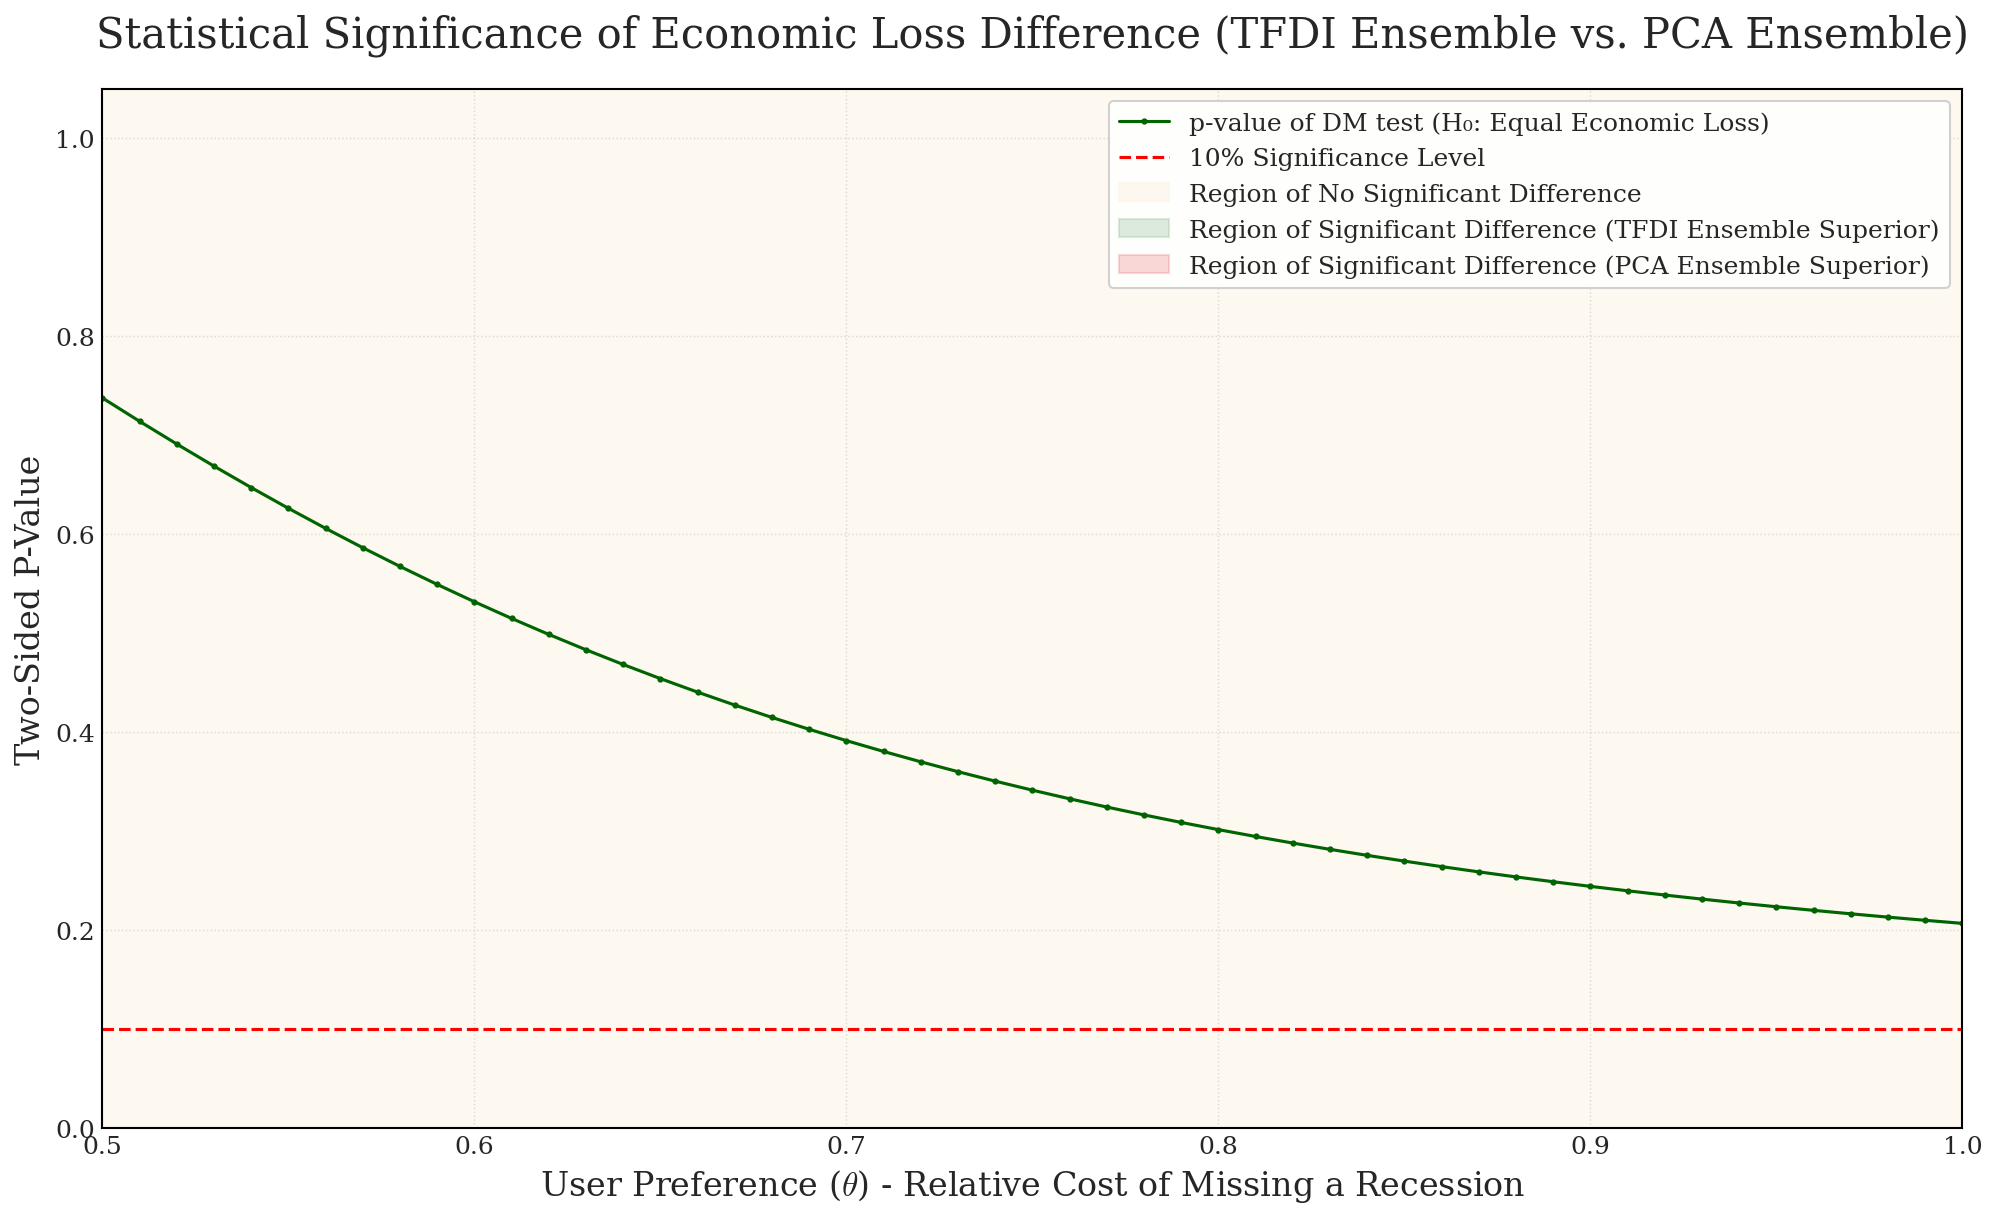

In [62]:
dm_results_df = pd.DataFrame({
    'theta': thetas,
    'p_value': p_values,
    'dm_stat': dm_stats
}).set_index('theta')


# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.fontset'] = 'cm' # Use computer modern for math symbols

fig, ax = plt.subplots(figsize=(16, 9))

# Plot the main p-value line
ax.plot(dm_results_df.index, dm_results_df['p_value'], marker='.', markersize=4, linestyle='-', color='darkgreen', label='p-value of DM test (H₀: Equal Economic Loss)')

# Plot the 10% significance level line
ax.axhline(0.10, color='red', linestyle='--', linewidth=1.5, label='10% Significance Level')

# Region of NO Significant Difference (p > 0.10)
no_sig_mask = dm_results_df['p_value'] > 0.10
ax.fill_between(dm_results_df.index, 0, 1.1, where=no_sig_mask, color='#FDF5E6', alpha=0.6, label='Region of No Significant Difference') # Use a soft, neutral color

# Region where our index is Significantly Superior (p <= 0.10 AND DM stat < 0)
hadi_wins_mask = (dm_results_df['p_value'] <= 0.10) & (dm_results_df['dm_stat'] < 0)
ax.fill_between(dm_results_df.index, 0, 1.1, where=hadi_wins_mask, color='darkseagreen', alpha=0.3, label=f'Region of Significant Difference ({challenger_title} Superior)')

# Region where PCA is Significantly Superior (p <= 0.10 AND DM stat > 0)
benchmark_wins_mask = (dm_results_df['p_value'] <= 0.10) & (dm_results_df['dm_stat'] > 0)
ax.fill_between(dm_results_df.index, 0, 1.1, where=benchmark_wins_mask, color='lightcoral', alpha=0.3, label=f'Region of Significant Difference ({benchmark_title} Superior)')


# Formaating
ax.set_title(f'Statistical Significance of Economic Loss Difference ({challenger_title} vs. {benchmark_title})', fontsize=20, pad=20)
ax.set_xlabel('User Preference ($\\theta$) - Relative Cost of Missing a Recession', fontsize=16)
ax.set_ylabel('Two-Sided P-Value', fontsize=16)
ax.set_ylim(0, 1.05)
ax.set_xlim(0.5, 1.0) # Focus on the relevant range
ax.grid(True, which='major', linestyle=':', linewidth=0.7, color='grey', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=12)

# Improve legend clarity
handles, labels = ax.get_legend_handles_labels()
# Define a professional order for the legend
order = [0, 1, 2, 3, 4] if len(labels) == 5 else [0, 1, 2, 3] # Adjust based on how many regions are plotted
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right', fontsize=12, frameon=True, fancybox=True, shadow=False, framealpha=0.9)


# Make the plot frame more prominent
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# plt.savefig(os.path.join(VISUALS_PATH, f'theta_plot_h1_{challenger_title}_{benchmark_title}.pdf'), bbox_inches='tight', dpi=300)
plt.show()

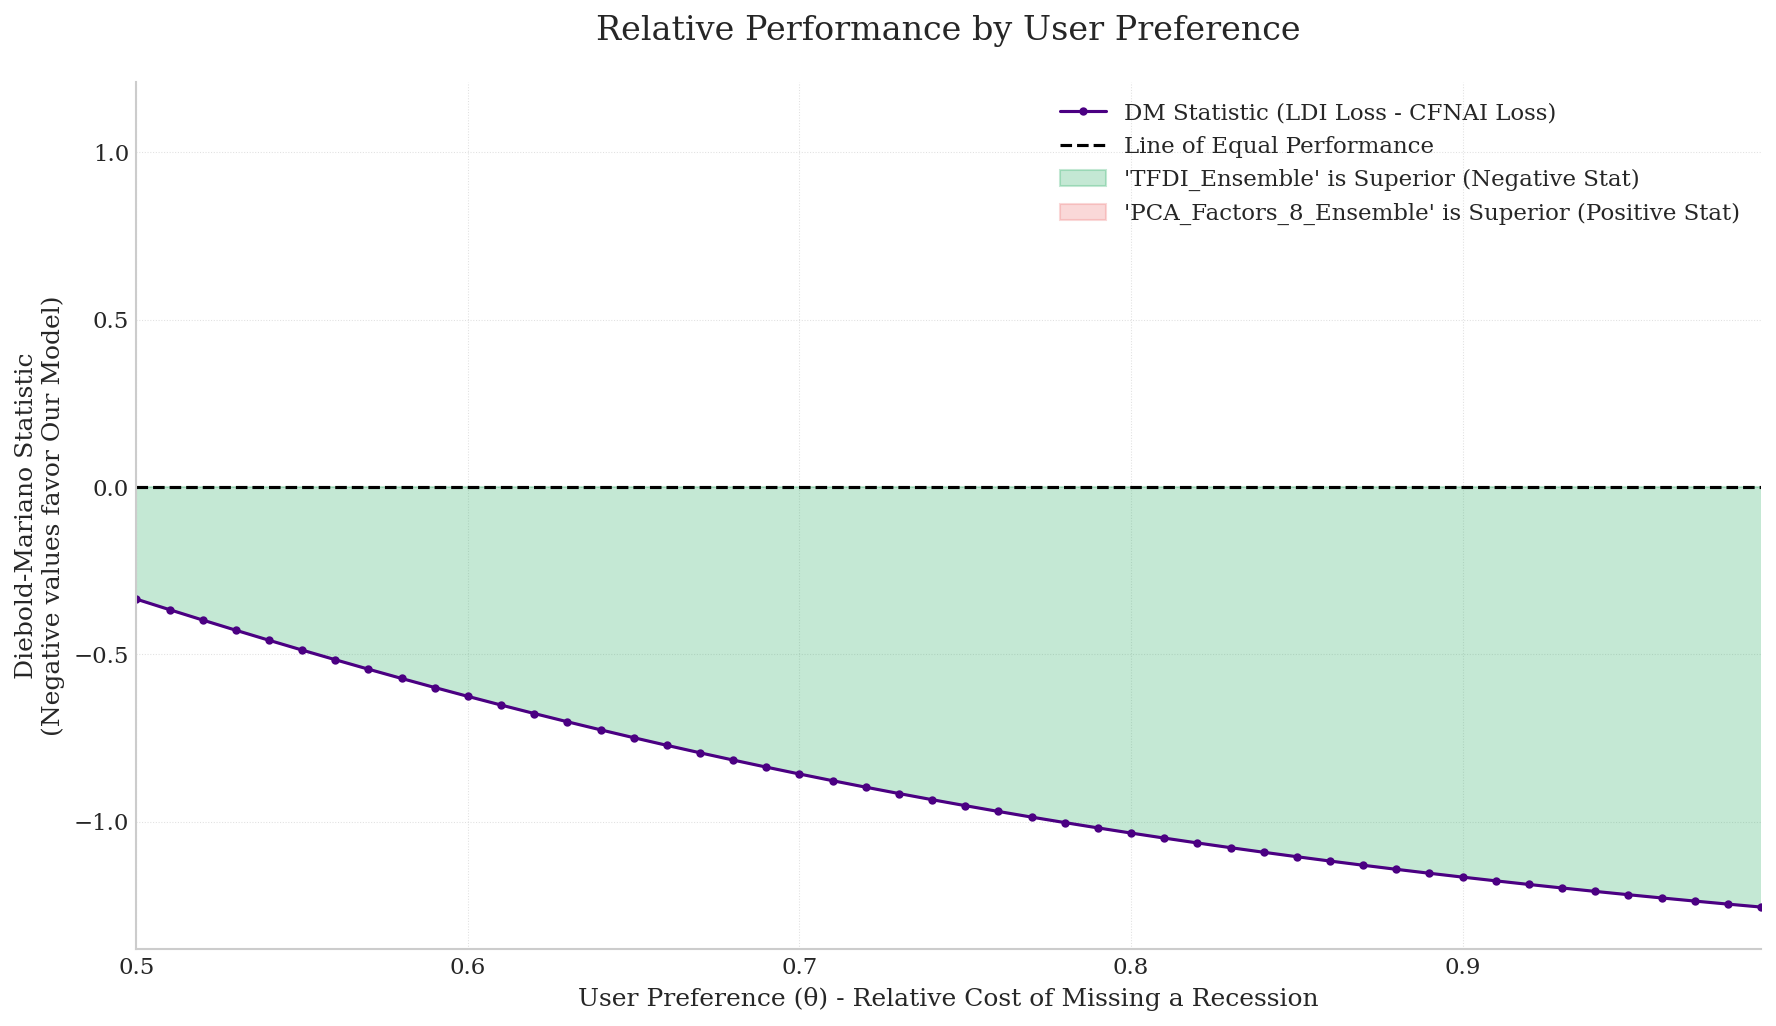

In [63]:
# COMPANION PLOT: VISUALIZING THE DIEBOLD-MARIANO STATISTIC


if 'dm_stats' in locals() and len(dm_stats) > 0:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot the DM statistic over the range of thetas
    ax.plot(thetas, dm_stats, marker='.', linestyle='-', color='indigo',
            label='DM Statistic (LDI Loss - CFNAI Loss)')

    # Add the zero line
    ax.axhline(0, color='black', linestyle='--', linewidth=1.5, label='Line of Equal Performance')


    # Negative values mean our diffusion index is better
    ax.fill_between(thetas, dm_stats, 0, where=[s < 0 for s in dm_stats],
                    color='mediumseagreen', alpha=0.3, interpolate=True,
                    label=f"'{challenger_model_name}' is Superior (Negative Stat)")

    # Positive values mean benchmark is better
    ax.fill_between(thetas, dm_stats, 0, where=[s > 0 for s in dm_stats],
                    color='lightcoral', alpha=0.3, interpolate=True,
                    label=f"'{benchmark_model_name}' is Superior (Positive Stat)")


    # Annotations and Labels
    ax.set_title(f'Relative Performance by User Preference', fontsize=16, pad=20)
    ax.set_xlabel('User Preference (θ) - Relative Cost of Missing a Recession', fontsize=12)
    ax.set_ylabel('Diebold-Mariano Statistic\n(Negative values favor Our Model)', fontsize=12)
    ax.set_xlim(0.5, 0.99)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()



    plt.tight_layout()
    plt.show()

else:
    print("Please run the previous DM test loop cell first to generate the 'dm_stats' variable.")

## Diagnostic Sandbox

Possible econ utility test, a lot of considerations though

In [ ]:
!pip install yfinance pandas_datareader -q
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd

#  Define the date range
start_date = '1989-12-01'
end_date = '2024-12-01'

print("Downloading asset price data...")

asset_returns = None # Initialize to None

try:
    #  Download S&P 500 data from Yahoo Finance
    sp500_data = yf.download('^GSPC', start=start_date, end=end_date, progress=False)

    #  Robust Column Selection (This is the corrected part)
    # yfinance column names can change. We check for standard names.
    if 'Adj Close' in sp500_data.columns:
        price_column = 'Adj Close'
    elif 'Close' in sp500_data.columns:
        price_column = 'Close'
    else:
        raise KeyError("Could not find 'Adj Close' or 'Close' in the downloaded S&P 500 data.")

    print(f"Using column '{price_column}' for S&P 500 calculations.")

    # Calculate monthly returns from the selected price column
    sp500_returns = sp500_data[price_column].resample('MS').first().pct_change()
    sp500_returns.name = 'SP'

    #  Download Bond Total Return Index data from FRED
    bond_data = web.DataReader('BAMLCC0A0CMTRIV', 'fred', start_date, end_date)
    bond_returns = bond_data['BAMLCC0A0CMTRIV'].resample('MS').first().pct_change()
    bond_returns.name = 'Bonds'

    #  Combine into a single DataFrame
    asset_returns = pd.concat([sp500_returns, bond_returns], axis=1).dropna()

    print("\\nAsset return data successfully processed.")
    print("Data available from:", asset_returns.index.min().date())
    print(asset_returns.head())

except Exception as e:
    print(f"\\nCould not download or process data. Error: {e}")

### Error diagnostics

 Diagnostic: Plotting the difference in forecast probabilities (TFDI_Ensemble - Weakness_Ensemble) 


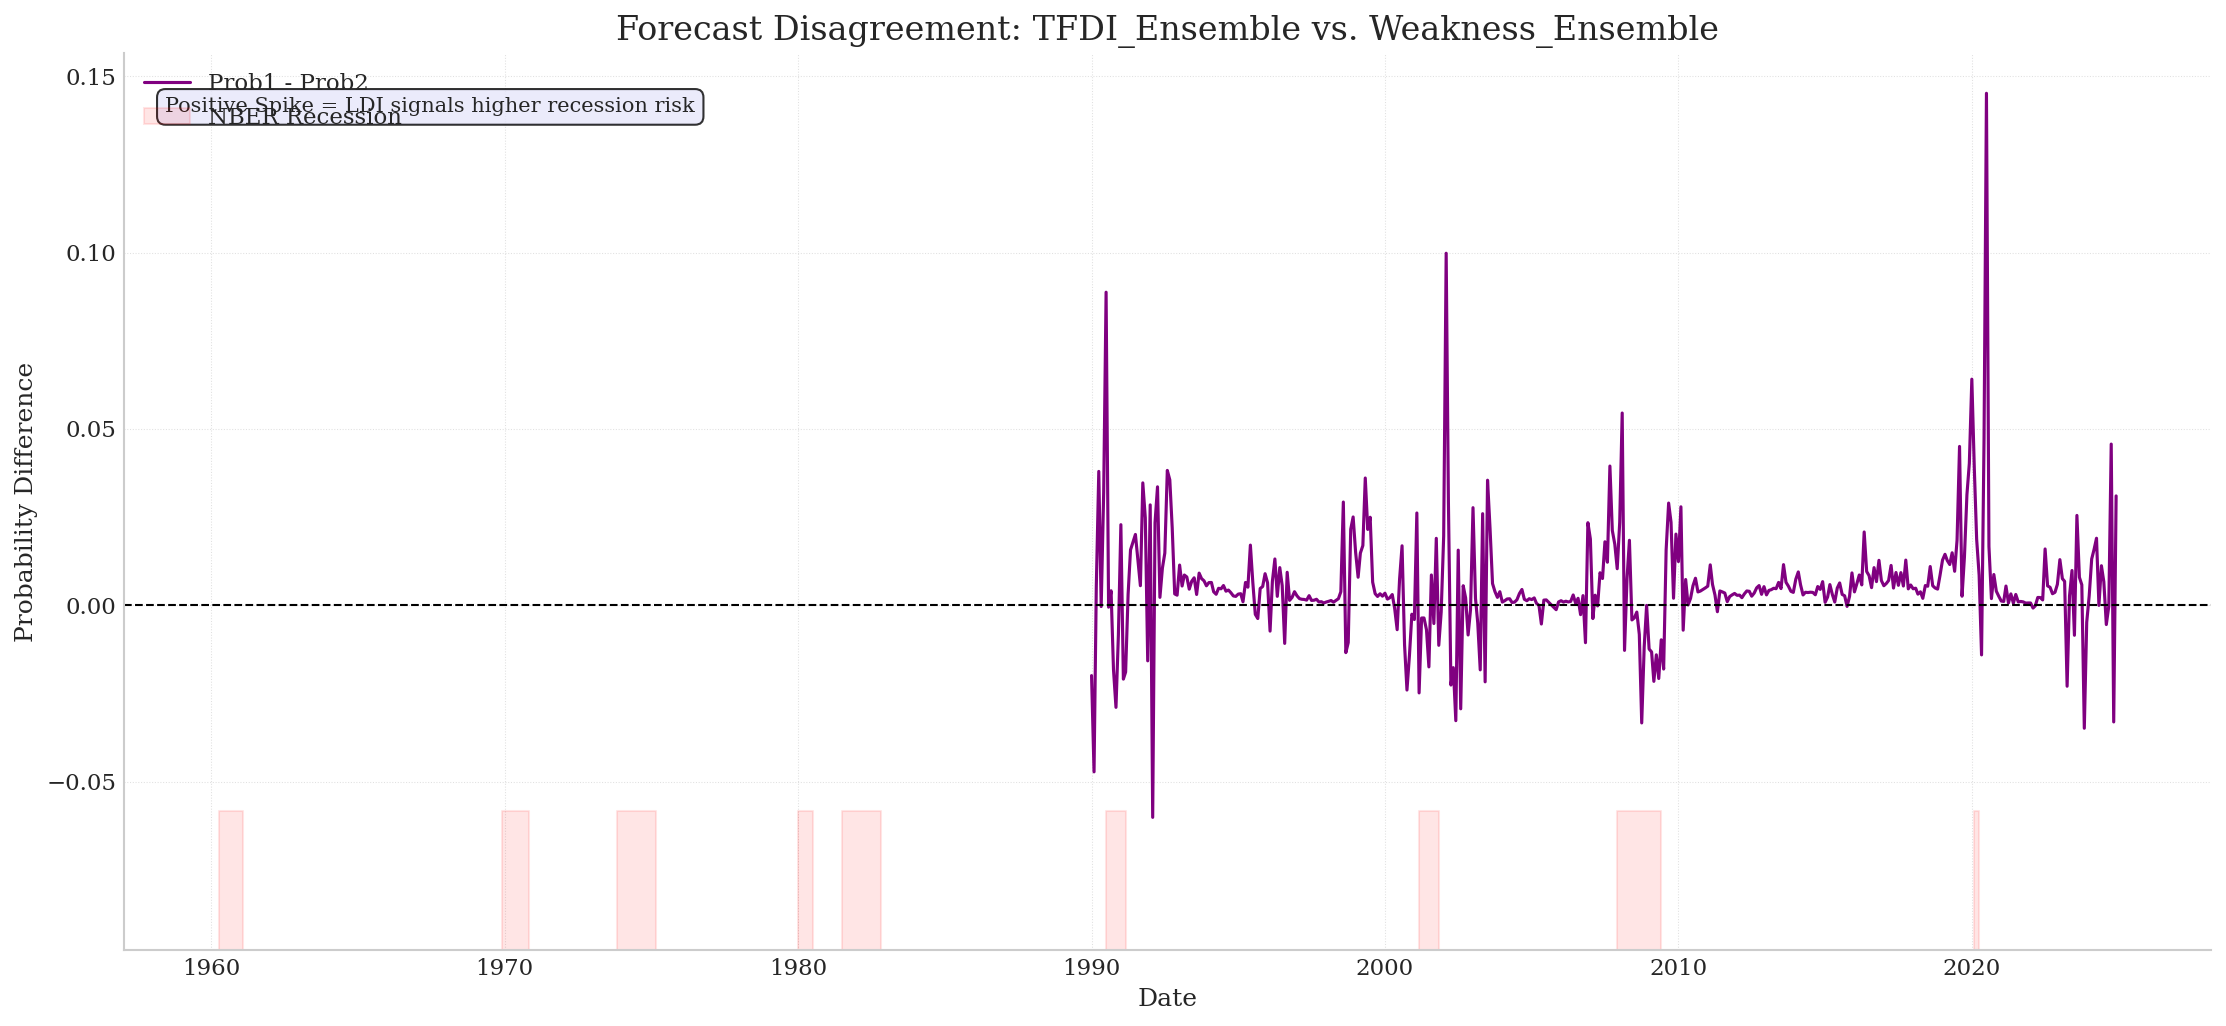


 Error Analysis 
                     | TFDI_Ensemble        | Weakness_Ensemble   
-----------------------------------------------------------------
SSE during RECESSIONS | 3.3008               | 3.5234              
SSE during EXPANSIONS | 4.3110               | 4.1968              
-----------------------------------------------------------------
Total SSE            | 7.6118               | 7.7202              

 Diagnostic Conclusion 
-> Our index makes smaller errors during RECESSION periods.
-> Weakness_Ensemble makes smaller errors during EXPANSION periods.


In [33]:
import pandas as pd
import matplotlib.pyplot as plt


# Prepare Data
model1_name = 'TFDI_Ensemble'
model2_name = 'Weakness_Ensemble'

print(f" Diagnostic: Plotting the difference in forecast probabilities ({model1_name} - {model2_name}) ")

df_diag = prob_df[[model1_name, model2_name]].dropna()
df_diag['Difference'] = df_diag[model1_name] - df_diag[model2_name]


fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df_diag.index, df_diag['Difference'], color='purple', label='Prob1 - Prob2')

# Add a zero line for reference
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Add recession shading for context
y_target_full_for_shading = pd.read_pickle(os.path.join(INTERMEDIATE_PATH, 'y_target.pkl'))
ax.fill_between(y_target_full_for_shading.index, ax.get_ylim()[0], ax.get_ylim()[1],
                where=y_target_full_for_shading['USRECM']==1, color='red', alpha=0.1,
                transform=ax.get_xaxis_transform(), label='NBER Recession')


ax.set_title(f'Forecast Disagreement: {model1_name} vs. {model2_name}', fontsize=16)
ax.set_ylabel('Probability Difference')
ax.set_xlabel('Date')
ax.legend(loc='upper left')
ax.grid(True, linestyle=':', alpha=0.6)

# Highlight key regions
ax.text(0.02, 0.95, 'Positive Spike = LDI signals higher recession risk',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.4', fc='lavender', alpha=0.8))

plt.tight_layout()
plt.show()

df_error = prob_df[['Actual_Recession', model1_name, model2_name]].dropna()

# Calculate squared errors for each model at each point in time
df_error['Loss_LDI'] = (df_error['Actual_Recession'] - df_error[model1_name])**2
df_error['Loss_PCA'] = (df_error['Actual_Recession'] - df_error[model2_name])**2

# Split errors
errors_in_recession = df_error[df_error['Actual_Recession'] == 1]
errors_in_expansion = df_error[df_error['Actual_Recession'] == 0]

# Compare SSE in each region
sse_di_recession = errors_in_recession['Loss_LDI'].sum()
sse_benchmark_recession = errors_in_recession['Loss_PCA'].sum()

sse_di_expansion = errors_in_expansion['Loss_LDI'].sum()
sse_benchmark_expansion = errors_in_expansion['Loss_PCA'].sum()

print(f"\n Error Analysis ")
print(f"{'':<20} | {model1_name:<20} | {model2_name:<20}")
print("-" * 65)
print(f"{'SSE during RECESSIONS':<20} | {sse_di_recession:<20.4f} | {sse_benchmark_recession:<20.4f}")
print(f"{'SSE during EXPANSIONS':<20} | {sse_di_expansion:<20.4f} | {sse_benchmark_expansion:<20.4f}")
print("-" * 65)
print(f"{'Total SSE':<20} | {df_error['Loss_LDI'].sum():<20.4f} | {df_error['Loss_PCA'].sum():<20.4f}")


print("\n Diagnostic Conclusion ")
if sse_di_recession < sse_benchmark_recession:
    print(f"-> Our index makes smaller errors during RECESSION periods.")
else:
    print(f"-> {model2_name} makes smaller errors during RECESSION periods.")

if sse_di_expansion < sse_benchmark_expansion:
    print(f"-> Our index makes smaller errors during EXPANSION periods.")
else:
    print(f"-> {model2_name} makes smaller errors during EXPANSION periods.")

In [ ]:
#  In your Evaluation Notebook
print("\n The Two Dimensions of Forecast Performance ")


models_to_plot = ['Deter_Ensemble', 'PCA_Factors_8_Ensemble', 'ADS_Ensemble', 'Yield_Ensemble']
aligned_df = prob_df[['Actual_Recession'] + models_to_plot].dropna()
y_true_test = aligned_df['Actual_Recession']


theta = 0.9

# Calculate Expansion vs. Recession Loss for Each Model
results = []
for model_name in models_to_plot:
    prob_test = aligned_df[model_name]

    # Calculate asymmetric absolute loss series
    loss_series = get_asymmetric_loss_series(y_true_test, prob_test, theta)

    # Decompose the loss
    expansion_mask = (y_true_test == 0)
    recession_mask = (y_true_test == 1)

    expansion_loss = loss_series[expansion_mask].sum()
    recession_loss = loss_series[recession_mask].sum()

    results.append({
        'Model': model_name,
        'Expansion_Loss': expansion_loss,
        'Recession_Loss': recession_loss
    })

results_df = pd.DataFrame(results)

# Create scatter plot
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
fig, ax = plt.subplots(figsize=(10, 8))

for i, row in results_df.iterrows():
    ax.scatter(row['Expansion_Loss'], row['Recession_Loss'], s=200, label=row['Model'], alpha=0.7)


for i, row in results_df.iterrows():
    ax.text(row['Expansion_Loss']*1.01, row['Recession_Loss']*1.01, row['Model'], fontsize=10)


ax.text(0.05, 0.05, 'Ideal Forecast\n(Low Expansion & Recession Loss)',
        transform=ax.transAxes, fontsize=12, ha='left', va='bottom', style='italic',
        bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.5))


ax.set_title('The Trade-Off Between Expansion Stability and Recession Accuracy', fontsize=16)
ax.set_xlabel('Total Asymmetric Loss During Expansions (Lower is Better)')
ax.set_ylabel('Total Asymmetric Loss During Recessions (Lower is Better)')
ax.legend().set_visible(False)

plt.show()